In [2]:
import mdtraj as md
from ase import Atoms
from nglview import show_ase
import networkx as nx

import torch
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGPooling, InnerProductDecoder
import torch_geometric.data as data
from torch_geometric.utils.convert import to_networkx

import numpy as np
import matplotlib.pyplot as plt


In [3]:
all_frames = md.load_xtc("../simulation/npt.xtc", top="../simulation/box.gro")


In [4]:
all_frames_fatures = []

for i in range(all_frames.xyz.shape[0]):
    mol_com_pos = []

    for res in all_frames.top.residues:
        # print(res.index,end=" ")
        pos = []
        for atom in res.atoms:
            # print(atom.index,"-->" , frame.xyz[0][atom.index],end=" ")
            pos.append(all_frames.xyz[i][atom.index])
        mol_com_pos.append(np.mean(pos,axis=0))
        
        # print()
    mol_com_pos = np.array(mol_com_pos).astype(np.float32)  
    all_frames_fatures.append(mol_com_pos)

all_frames_fatures = np.array(all_frames_fatures).astype(np.float32)
print(all_frames_fatures.shape)

(51, 101, 3)


In [5]:
print(dir(all_frames.topology.residue(0)))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_atoms', 'atom', 'atoms', 'atoms_by_name', 'chain', 'code', 'index', 'is_nucleic', 'is_protein', 'is_water', 'n_atoms', 'name', 'resSeq', 'segment_id']


In [6]:
n_frames = all_frames.xyz.shape[0]
n_atoms = all_frames.topology.residue(0).n_atoms
n_mols = all_frames.topology.n_residues

In [7]:
print("number of molecules",n_mols)
print("number of atoms in molecule",n_atoms)
print("number of frames",n_frames)

number of molecules 101
number of atoms in molecule 4
number of frames 51


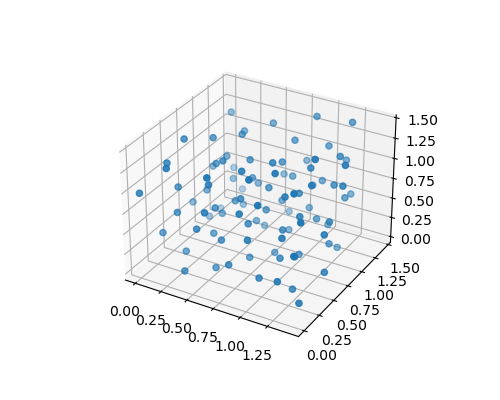

In [8]:
%matplotlib widget

frame = 10

fig = plt.figure(figsize=(5,4))
ax1 = fig.add_subplot(projection='3d')
ax1.scatter(all_frames_fatures[frame][:,0],all_frames_fatures[frame][:,1],all_frames_fatures[frame][:,2])
plt.show()

In [9]:
def convert_to_adj(edge_index, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max() + 1
    adj = torch.zeros(num_nodes, num_nodes)
    adj[edge_index[0], edge_index[1]] = 1
    return adj

def convert_to_edge_index(adj):
    edge_index = adj.nonzero().t()
    return edge_index

In [10]:
cutoff = 0.5

all_edge_list = []
for frame_i in range(n_frames):
    from_list = []
    to_list = []

    for i in range(len(all_frames_fatures[frame_i])):
        for j in range(i+1,len(all_frames_fatures[frame_i])):
            if np.linalg.norm(all_frames_fatures[frame_i][i]-all_frames_fatures[frame_i][j]) < cutoff:
                # print(i,j,np.linalg.norm(mol_com_pos[i]-mol_com_pos[j]))
                from_list.append(i)
                to_list.append(j)

                to_list.append(i)
                from_list.append(j)

    edge_list = np.array([from_list,to_list]).astype(np.int64)
    all_edge_list.append(edge_list)

print(len(all_edge_list))

51


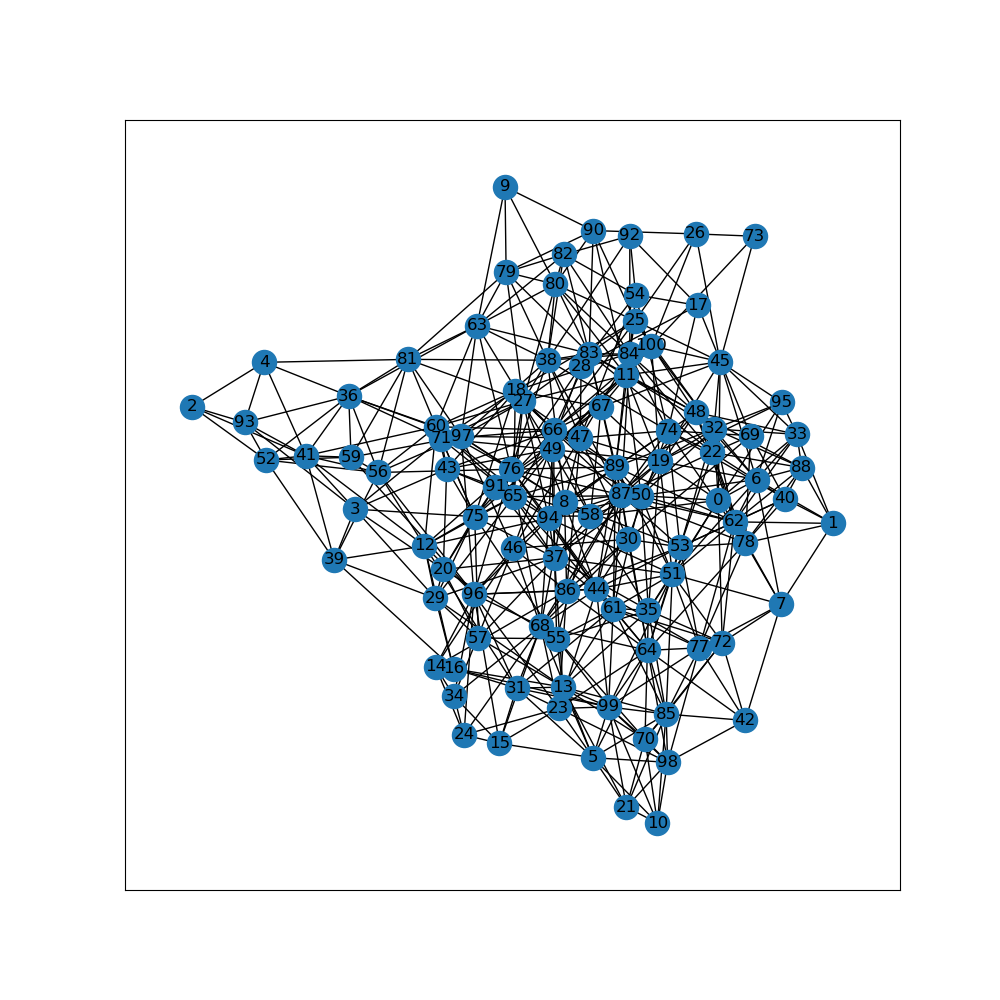

In [11]:
%matplotlib widget

frame = 10

plt.figure(figsize=(10,10))
adj_binary = convert_to_adj(all_edge_list[frame], num_nodes=101)
indices = torch.where(adj_binary)
G = nx.Graph()
edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
G.add_edges_from(edges)
nx.draw_networkx(G)


In [12]:
graphs = []
for frame in range(n_frames):
    g = data.Data(x=torch.tensor(all_frames_fatures[frame]).float(), edge_index=torch.tensor(all_edge_list[frame]).long(), y=torch.tensor([0]))
    graphs.append(g)

print(graphs[0])
graphs

Data(x=[101, 3], edge_index=[2, 1158], y=[1])


[Data(x=[101, 3], edge_index=[2, 1158], y=[1]),
 Data(x=[101, 3], edge_index=[2, 1182], y=[1]),
 Data(x=[101, 3], edge_index=[2, 1092], y=[1]),
 Data(x=[101, 3], edge_index=[2, 1144], y=[1]),
 Data(x=[101, 3], edge_index=[2, 1132], y=[1]),
 Data(x=[101, 3], edge_index=[2, 1114], y=[1]),
 Data(x=[101, 3], edge_index=[2, 1128], y=[1]),
 Data(x=[101, 3], edge_index=[2, 1094], y=[1]),
 Data(x=[101, 3], edge_index=[2, 1082], y=[1]),
 Data(x=[101, 3], edge_index=[2, 1156], y=[1]),
 Data(x=[101, 3], edge_index=[2, 1098], y=[1]),
 Data(x=[101, 3], edge_index=[2, 1106], y=[1]),
 Data(x=[101, 3], edge_index=[2, 1050], y=[1]),
 Data(x=[101, 3], edge_index=[2, 1038], y=[1]),
 Data(x=[101, 3], edge_index=[2, 988], y=[1]),
 Data(x=[101, 3], edge_index=[2, 1062], y=[1]),
 Data(x=[101, 3], edge_index=[2, 1066], y=[1]),
 Data(x=[101, 3], edge_index=[2, 1052], y=[1]),
 Data(x=[101, 3], edge_index=[2, 1038], y=[1]),
 Data(x=[101, 3], edge_index=[2, 1106], y=[1]),
 Data(x=[101, 3], edge_index=[2, 1134], y

In [13]:
from typing import Optional, Tuple

import torch
from torch import Tensor
from torch.nn import Module

from torch_geometric.nn.inits import reset
from torch_geometric.utils import negative_sampling

EPS = 1e-15
MAX_LOGSTD = 10


class InnerProductDecoder(torch.nn.Module):
    r"""The inner product decoder from the `"Variational Graph Auto-Encoders"
    <https://arxiv.org/abs/1611.07308>`_ paper

    .. math::
        \sigma(\mathbf{Z}\mathbf{Z}^{\top})

    where :math:`\mathbf{Z} \in \mathbb{R}^{N \times d}` denotes the latent
    space produced by the encoder."""

    def forward(self, z: Tensor, edge_index: Tensor,
                sigmoid: bool = True) -> Tensor:
        r"""Decodes the latent variables :obj:`z` into edge probabilities for
        the given node-pairs :obj:`edge_index`.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return torch.sigmoid(value) if sigmoid else value

    def forward_all(self, z: Tensor, sigmoid: bool = True) -> Tensor:
        r"""Decodes the latent variables :obj:`z` into a probabilistic dense
        adjacency matrix.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        adj = torch.matmul(z, z.t())
        return torch.sigmoid(adj) if sigmoid else adj


class GAE(torch.nn.Module):
    r"""The Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper based on user-defined encoder and decoder models.

    Args:
        encoder (torch.nn.Module): The encoder module.
        decoder (torch.nn.Module, optional): The decoder module. If set to
            :obj:`None`, will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """

    def __init__(self, encoder: Module, decoder: Optional[Module] = None):
        super().__init__()
        self.encoder = encoder
        self.decoder = InnerProductDecoder() if decoder is None else decoder
        GAE.reset_parameters(self)

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        reset(self.encoder)
        reset(self.decoder)

    def forward(self, *args, **kwargs) -> Tensor:  # pragma: no cover
        r"""Alias for :meth:`encode`."""
        return self.encoder(*args, **kwargs)

    def encode(self, *args, **kwargs) -> Tensor:
        r"""Runs the encoder and computes node-wise latent variables."""
        return self.encoder(*args, **kwargs)

    def decode(self, *args, **kwargs) -> Tensor:
        r"""Runs the decoder and computes edge probabilities."""
        return self.decoder(*args, **kwargs)

    def recon_loss(self, z: Tensor, pos_edge_index: Tensor,
                   neg_edge_index: Optional[Tensor] = None) -> Tensor:
        r"""Given latent variables :obj:`z`, computes the binary cross
        entropy loss for positive edges :obj:`pos_edge_index` and negative
        sampled edges.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (torch.Tensor): The positive edges to train against.
            neg_edge_index (torch.Tensor, optional): The negative edges to
                train against. If not given, uses negative sampling to
                calculate negative edges. (default: :obj:`None`)
        """
        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index, sigmoid=True)[0] + EPS).mean()

        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
        neg_loss = -torch.log(1 -
                              self.decoder(z, neg_edge_index.long(), sigmoid=True)[0] +
                              EPS).mean()

        return pos_loss + neg_loss

    def test(self, z: Tensor, pos_edge_index: Tensor,
             neg_edge_index: Tensor) -> Tuple[Tensor, Tensor]:
        r"""Given latent variables :obj:`z`, positive edges
        :obj:`pos_edge_index` and negative edges :obj:`neg_edge_index`,
        computes area under the ROC curve (AUC) and average precision (AP)
        
        scores.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (torch.Tensor): The positive edges to evaluate
                against.
            neg_edge_index (torch.Tensor): The negative edges to evaluate
                against.
        """
        from sklearn.metrics import average_precision_score, roc_auc_score

        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)

        pos_pred = self.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = self.decoder(z, neg_edge_index, sigmoid=True)
        pred = torch.cat([pos_pred, neg_pred], dim=0)

        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()

        return roc_auc_score(y, pred), average_precision_score(y, pred)


class VGAE(GAE):
    r"""The Variational Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper.

    Args:
        encoder (torch.nn.Module): The encoder module to compute :math:`\mu`
            and :math:`\log\sigma^2`.
        decoder (torch.nn.Module, optional): The decoder module. If set to
            :obj:`None`, will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """

    def __init__(self, encoder: Module, decoder: Optional[Module] = None):
        super().__init__(encoder, decoder)

    def reparametrize(self, mu: Tensor, logstd: Tensor) -> Tensor:
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu

    def encode(self, *args, **kwargs) -> Tensor:
        """"""
        self.__mu__, self.__logstd__, self.edge_index = self.encoder(
            *args, **kwargs)
        self.__logstd__ = self.__logstd__.clamp(max=MAX_LOGSTD)
        z = self.reparametrize(self.__mu__, self.__logstd__)
        return z, self.edge_index

    def kl_loss(self, mu: Optional[Tensor] = None,
                logstd: Optional[Tensor] = None) -> Tensor:
        r"""Computes the KL loss, either for the passed arguments :obj:`mu`
        and :obj:`logstd`, or based on latent variables from last encoding.

        Args:
            mu (torch.Tensor, optional): The latent space for :math:`\mu`. If
                set to :obj:`None`, uses the last computation of :math:`\mu`.
                (default: :obj:`None`)
            logstd (torch.Tensor, optional): The latent space for
                :math:`\log\sigma`.  If set to :obj:`None`, uses the last
                computation of :math:`\log\sigma^2`. (default: :obj:`None`)
        """
        mu = self.__mu__ if mu is None else mu
        logstd = self.__logstd__ if logstd is None else logstd.clamp(
            max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))


Checkpoint-1



In [37]:
def norm_g(g):
    degrees = torch.sum(g, 1)
    g = g / degrees
    return g


def top_k_graph(scores, g, h, k):
    num_nodes = g.shape[0]
    values, idx = torch.topk(scores, max(2, int(k*num_nodes)))
    new_h = h[idx, :]
    values = torch.unsqueeze(values, -1)
    new_h = torch.mul(new_h, values)
    un_g = g.bool().float()
    un_g = torch.matmul(un_g, un_g).bool().float()
    un_g = un_g[idx, :]
    un_g = un_g[:, idx]
    g = norm_g(un_g)
    return g, new_h, idx

class Pool(torch.nn.Module):

    def __init__(self, k, in_dim, p):
        super(Pool, self).__init__()
        self.k = k
        self.sigmoid = torch.nn.Sigmoid()
        self.proj = torch.nn.Linear(in_dim, 1)
        self.drop = torch.nn.Dropout(p=p) if p > 0 else torch.nn.Identity()

    def forward(self, g, h):
        Z = self.drop(h)
        weights = self.proj(Z).squeeze()
        scores = self.sigmoid(weights)
        return top_k_graph(scores, g, h, self.k)


class Unpool(torch.nn.Module):

    def __init__(self, *args):
        super(Unpool, self).__init__()

    def forward(self, h, edge_indices,factor=1):
        # add zeros to h factor times
        # changes made to h factor times
        h = torch.cat([h, torch.zeros(h.shape[0]*factor, h.shape[1]).to(h.device)], dim=0)
        return h

In [38]:
import torch.nn.functional as F

class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2*out_channels, 1 * out_channels)
        # add pooling layer here 
        #self defined is better 
        self.pool = SAGPooling(in_channels, 0.5)
        self.conv_mu = GCNConv(1 * out_channels, out_channels)
        self.conv_logstd = GCNConv(1 * out_channels, out_channels)

    def forward(self, x, edge_index):
        #self pooling layers here to return the mu, logstd, edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu   
        x, edge_index,_,_,_,_ = self.pool(x, edge_index)
        mu = self.conv_mu(x, edge_index)
        logstd = self.conv_logstd(x, edge_index)
        
        return mu, logstd, edge_index

In [39]:
class VariationalGCNDecoder(torch.nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        #unpool layer to be added here
        self.unpool= Unpool()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, 1 * out_channels)
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)
        
    def forward(self, x, edge_index, sigmoid=True):
        x=self.unpool(x, edge_index, factor=1)
        edge_index = torch.cat([edge_index, torch.zeros(2,max(0,z.shape[0]-edge_index.shape[1]) ).long()], dim=1)
      
        x = self.conv1(x.float(), edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return x, edge_index

In [40]:
#changes to n_epochs out_channels and batch_size
in_channels = graphs[0].num_features
out_channels = 3
lr = 1e-4
n_epochs = 20
batch_size=1

model = VGAE(VariationalGCNEncoder(in_channels, out_channels),
             VariationalGCNDecoder(out_channels, in_channels))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [41]:
train_loader = DataLoader(graphs, batch_size=batch_size)

In [42]:
for data in train_loader:
    print((data.x.type()))
    print((data.edge_index.type()))
    break

torch.FloatTensor
torch.LongTensor


Checkpoint-2

In [ ]:
def train():
    model.train()
    model.zero_grad()
    model.float()
    loss_all = 0
    for data in train_loader:
        optimizer.zero_grad()
        z, encoded_edge = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge = model.decode(z, encoded_edge)
        print("x", data.x.shape)
        print("edge", data.edge_index.shape)
        print("decoded x", decoded_x.shape)
        print("decoded edge", decoded_edge.shape)
        lossF = F.mse_loss(decoded_x, data.x)
        lossE = F.mse_loss(data.edge_index, decoded_edge.float())
        loss = lossF + lossE
        loss = loss + (1 / data.num_nodes) * model.kl_loss()
        loss.backward()
        loss_all += float(loss)
        optimizer.step()
    return loss_all / len(train_loader.dataset)



In [45]:
import torch
import torch.nn.functional as F

def train():
    model.train()
    model.zero_grad()
    model.float()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0

    for data in train_loader:
        optimizer.zero_grad()
        z, encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        feature_loss = F.mse_loss(decoded_x, data.x)
        edge_loss = F.mse_loss(decoded_edge_index.float(), data.edge_index)
        loss = feature_loss + edge_loss
        loss = loss + (1 / data.num_nodes) * model.kl_loss()

        loss_all += float(loss)
        feature_loss_all += float(feature_loss)
        edge_loss_all += float(edge_loss)
        kl_loss_all += float(model.kl_loss() / data.num_nodes)

        loss.backward()
        optimizer.step()

    return (
        loss_all / len(train_loader.dataset),
        feature_loss_all / len(train_loader.dataset),
        edge_loss_all / len(train_loader.dataset),
        kl_loss_all / len(train_loader.dataset)
    )


In [46]:
total_losses = []
for epoch in range(1, n_epochs + 1):
    total_loss= train()
    print(f'Epoch: {epoch:03d}, Total Loss: {total_loss:.4f}')
    total_losses.append(total_loss)
    

AttributeError: 'builtin_function_or_method' object has no attribute 'size'

In [105]:
plt.figure(figsize=(12, 5))
plt.plot(total_losses, label='Total Loss')
plt.show()


In [106]:
graphs

In [47]:
model.double()
x_values = [data.x for data in graphs]
edge_index_values = [data.edge_index for data in graphs]
z,encoded_edge_index = model.encode(x_values, edge_index_values)
r,decoded_edge_index = model.decode(z, encoded_edge_index)
decoded_edge_index = graphs.edge_index
print("Input Graphs features: \n", graphs.x)
print("\nInput Edge Index: \n", graphs.edge_index)
print("\nEncoded Graphs: \n", z)
print("\nDecoded Node features: \n", r)
print("\nDecoded Edge Index: \n", decoded_edge_index)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not list

In [108]:
add_self_loops = False
adj_binary = convert_to_adj(decoded_edge_index, r.shape[0])
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(
        indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
G.add_node(4)
nx.draw_networkx(G, with_labels=True)
plt.show()

In [ ]:
`